In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [12]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        # Sigmoid
        if num_params == 4:
            h_base = torch.tensor([0.9813, -1.9998, -0.6859, 0.0726])
            d_base = torch.tensor([0.4719, 0.8930, -0.2312, -0.1692])
            T_base = torch.tensor([-1.2178, -0.0103, 0.9895, 0.9898])
        elif num_params == 8:
            h_base = torch.tensor([6.8620, 3.8446, 3.4882, 1.5610, 1.1893, 1.4751, -2.6189, 0.1495])
            d_base = torch.tensor([0.0891, 0.6711, 0.0253, 0.1613, -0.0060, -0.0086, 0.9554, -0.7933])
            T_base = torch.tensor([9.2329, 0.0567, 2.0161, -1.2216, 0.5962, -0.3178, -2.6367, -1.0322])
        elif num_params == 12:
            h_base = torch.tensor([1.9139, 1.2510, 2.0618, 0.7526, 1.5032, 0.3668, 1.9875, 1.1889, 0.5554, 0.4489, 1.1767, 0.1623])
            d_base = torch.tensor([0.4217, 0.2337, 0.1932, 0.0021, 0.0887, 0.0465, 0.0138, 1.2080, -0.0026, 0.1974, 0.0001, 0.0001])
            T_base = torch.tensor([0.0443, -0.9573, -1.5970, 2.4553, -2.7807, -3.4746, -2.0787, 1.7883, 0.7193, 3.4051, 0.2201, -0.0492])
        elif num_params == 16:
            h_base = torch.tensor([2.5733, 1.3121, 0.8950, 1.0941, 1.5366, 0.5694, 1.4563, 0.9944, 1.0961, -1.9481, 1.2481, 0.3490, 0.4921, 0.7793, 2.7194, 1.0211])
            d_base = torch.tensor([0.5183, 0.2210, 0.0476, 0.0298, 0.0310, 0.0015, 0.0008, 0.0011, 0.0026, 0.3293, -0.2537, 1.2654, 0.8791, 0.0033, 0.0023, 0.0710])
            T_base = torch.tensor([0.1467, -1.1673, -2.9088, -4.0010, -2.0569, 0.0914, 0.6653, 0.5048, 0.2919, -4.0346, -3.0172, 1.8976, 1.8881, 0.3116, 0.0206, -2.8496])

        # Use Laplace noise
        self.h = nn.Parameter(h_base + torch.distributions.Laplace(0, 0.0001).sample(h_base.size()))
        self.d = nn.Parameter(d_base + torch.distributions.Laplace(0, 0.0001).sample(d_base.size()))
        self.T = nn.Parameter(T_base + torch.distributions.Laplace(0, 0.0001).sample(T_base.size()))
    
    def add_noise(self):
        self.h.data += torch.distributions.Laplace(0, 0.0001).sample(self.h.size())
        self.d.data += torch.distributions.Laplace(0, 0.0001).sample(self.d.size())
        self.T.data += torch.distributions.Laplace(0, 0.0001).sample(self.T.size())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

Epoch 1/20000, Loss: 0.005719666834920645
Epoch 1001/20000, Loss: 0.005719722714275122
Epoch 2001/20000, Loss: 0.005719543434679508
Epoch 3001/20000, Loss: 0.005719663109630346
Epoch 4001/20000, Loss: 0.005720026791095734
Epoch 5001/20000, Loss: 0.005719629116356373
Epoch 6001/20000, Loss: 0.00571995135396719
Epoch 7001/20000, Loss: 0.0057197511196136475
Epoch 8001/20000, Loss: 0.0057197632268071175
Epoch 9001/20000, Loss: 0.005720564629882574
Epoch 10001/20000, Loss: 0.005720160901546478
Epoch 11001/20000, Loss: 0.0057198950089514256
Epoch 12001/20000, Loss: 0.005719837732613087
Epoch 13001/20000, Loss: 0.005720118526369333
Epoch 14001/20000, Loss: 0.005719990003854036
Epoch 15001/20000, Loss: 0.005719946231693029
Epoch 16001/20000, Loss: 0.0057196239940822124
Epoch 17001/20000, Loss: 0.005719722714275122
Epoch 18001/20000, Loss: 0.005719971377402544
Epoch 19001/20000, Loss: 0.005720099899917841
Loss values: [0.005719666834920645, 0.0057203881442546844, 0.005720215849578381, 0.0057196

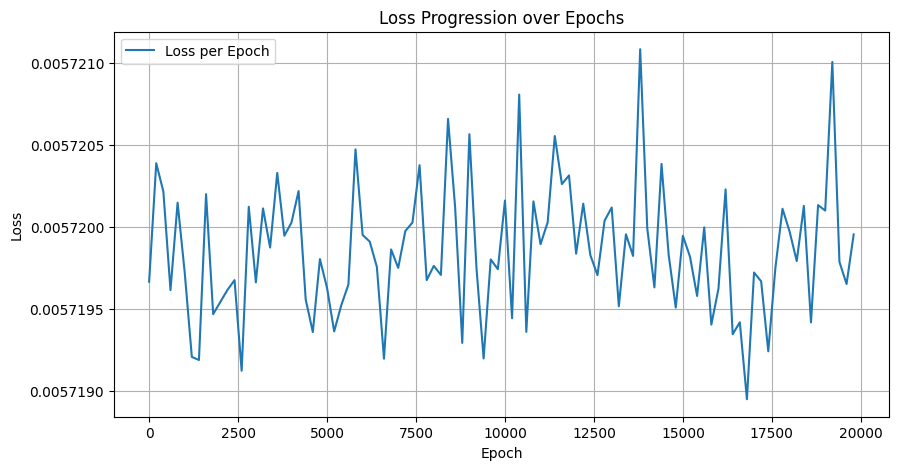

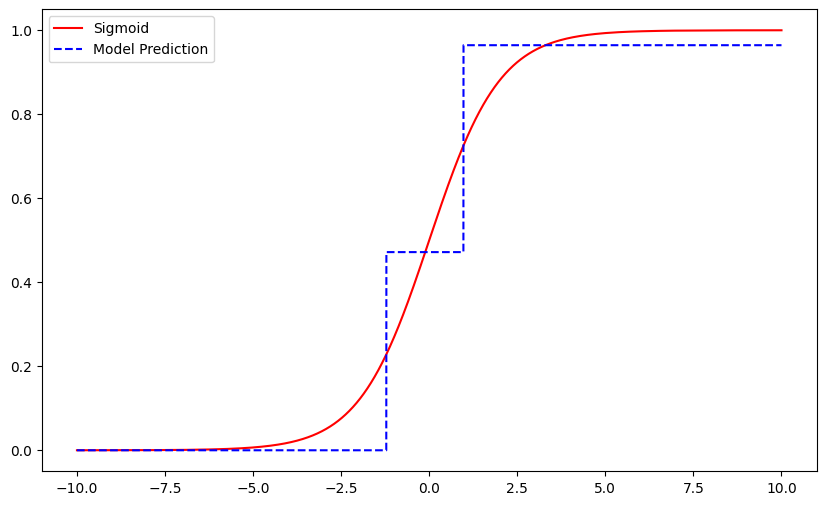

In [13]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.0022764403838664293
Epoch 1001/20000, Loss: 0.001911745872348547
Epoch 2001/20000, Loss: 0.0018381322734057903
Epoch 3001/20000, Loss: 0.0021149099338799715
Epoch 4001/20000, Loss: 0.0016726822359487414
Epoch 5001/20000, Loss: 0.0015266366535797715
Epoch 6001/20000, Loss: 0.0014759593177586794
Epoch 7001/20000, Loss: 0.001442891894839704
Epoch 8001/20000, Loss: 0.0014244774356484413
Epoch 9001/20000, Loss: 0.0014179300051182508
Epoch 10001/20000, Loss: 0.0014121972490102053
Epoch 11001/20000, Loss: 0.0014063224662095308
Epoch 12001/20000, Loss: 0.0013969583669677377
Epoch 13001/20000, Loss: 0.0013929131673648953
Epoch 14001/20000, Loss: 0.0013923089718446136
Epoch 15001/20000, Loss: 0.0013897493481636047
Epoch 16001/20000, Loss: 0.0013917791657149792
Epoch 17001/20000, Loss: 0.0013894017320126295
Epoch 18001/20000, Loss: 0.0013970915460959077
Epoch 19001/20000, Loss: 0.0013902753125876188
Loss values: [0.0022764403838664293, 0.002136720810085535, 0.00215183291584

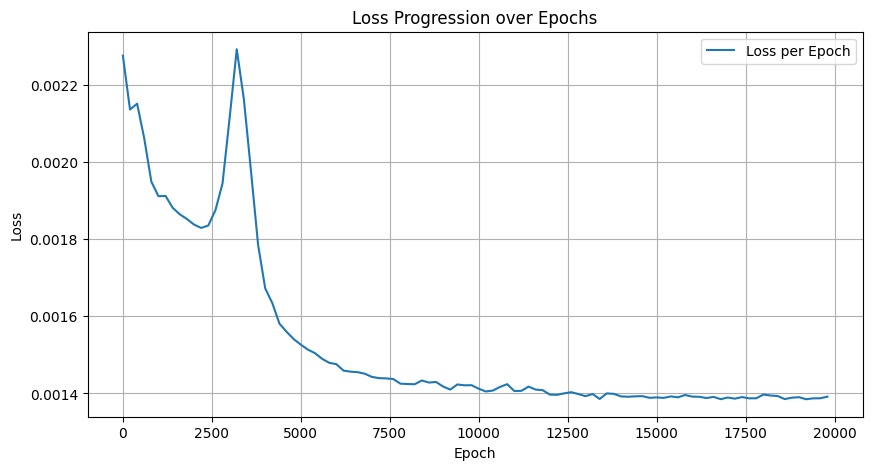

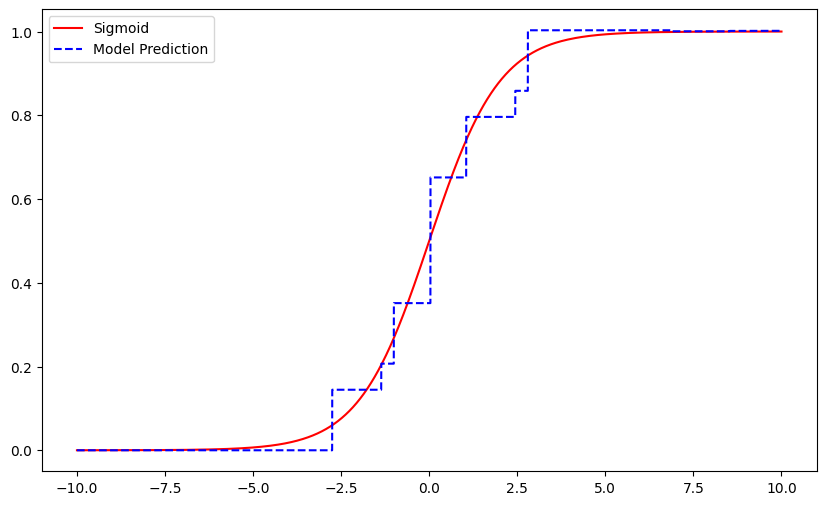

In [14]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.00015760980022605509
Epoch 1001/20000, Loss: 0.00015203624207060784
Epoch 2001/20000, Loss: 0.0001431116252206266
Epoch 3001/20000, Loss: 0.0001140907479566522
Epoch 4001/20000, Loss: 0.00011810084106400609
Epoch 5001/20000, Loss: 9.895681432681158e-05
Epoch 6001/20000, Loss: 8.236143185058609e-05
Epoch 7001/20000, Loss: 7.399726018775254e-05
Epoch 8001/20000, Loss: 8.08942859293893e-05
Epoch 9001/20000, Loss: 6.226886034710333e-05
Epoch 10001/20000, Loss: 5.90901036048308e-05
Epoch 11001/20000, Loss: 5.743854489992373e-05
Epoch 12001/20000, Loss: 5.286034502205439e-05
Epoch 13001/20000, Loss: 4.8280126065947115e-05
Epoch 14001/20000, Loss: 4.9995134759228677e-05
Epoch 15001/20000, Loss: 5.088722537038848e-05
Epoch 16001/20000, Loss: 5.1287919632159173e-05
Epoch 17001/20000, Loss: 4.8204947233898565e-05
Epoch 18001/20000, Loss: 3.874774483847432e-05
Epoch 19001/20000, Loss: 4.135139533900656e-05
Loss values: [0.00015760980022605509, 0.0001665313757257536, 0.00018

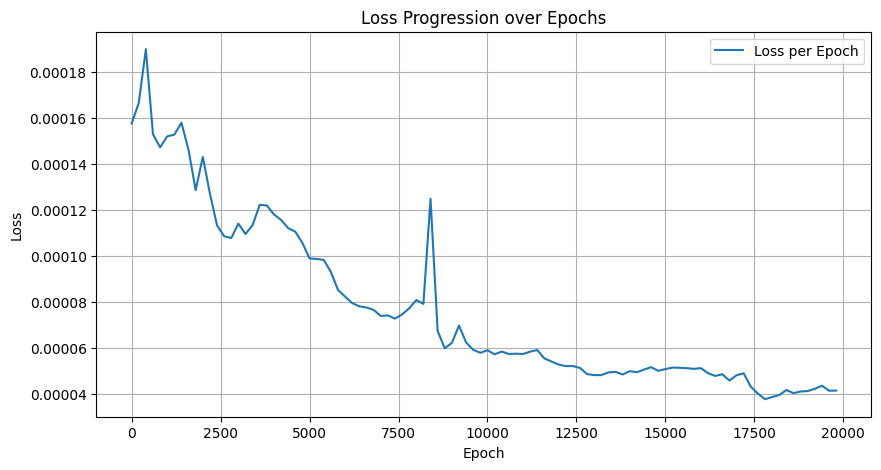

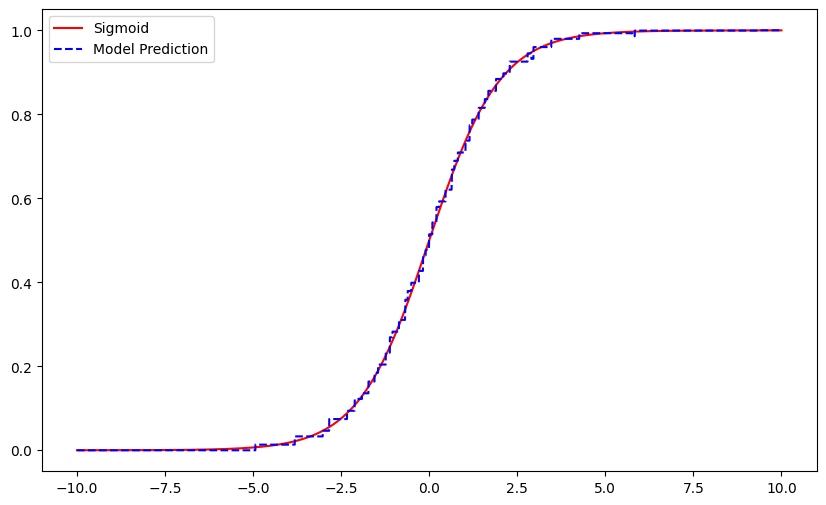

In [15]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.000293334131129086
Epoch 1001/20000, Loss: 0.0003385385498404503
Epoch 2001/20000, Loss: 0.0003897889982908964
Epoch 3001/20000, Loss: 0.0004416362789925188
Epoch 4001/20000, Loss: 0.00047896435717120767
Epoch 5001/20000, Loss: 0.0005026526050642133
Epoch 6001/20000, Loss: 0.0005189413204789162
Epoch 7001/20000, Loss: 0.0005063966964371502
Epoch 8001/20000, Loss: 0.000498532666824758
Epoch 9001/20000, Loss: 0.0005254290881566703
Epoch 10001/20000, Loss: 0.000524139148183167
Epoch 11001/20000, Loss: 0.0005268422537483275
Epoch 12001/20000, Loss: 0.0005249856039881706
Epoch 13001/20000, Loss: 0.0005274154245853424
Epoch 14001/20000, Loss: 0.0005308599211275578
Epoch 15001/20000, Loss: 0.0005064805154688656
Epoch 16001/20000, Loss: 0.0005056742811575532
Epoch 17001/20000, Loss: 0.0005040680407546461
Epoch 18001/20000, Loss: 0.0005038796807639301
Epoch 19001/20000, Loss: 0.000497779343277216
Loss values: [0.000293334131129086, 0.0003067447687499225, 0.000313189899316

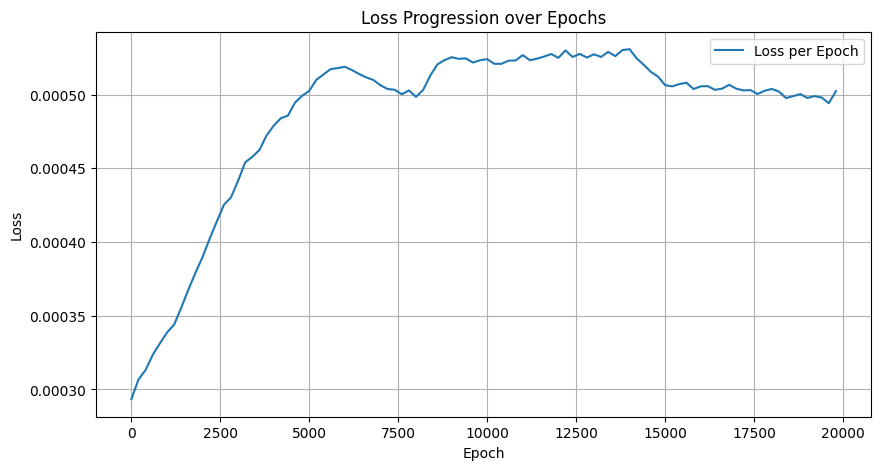

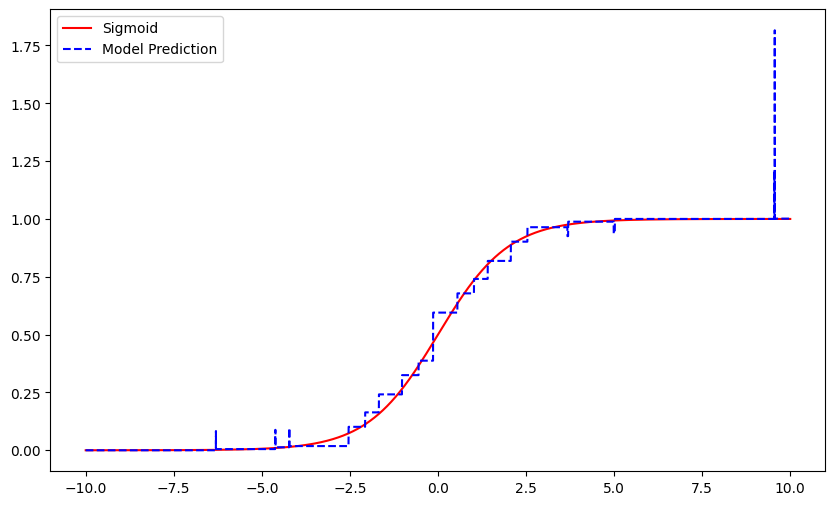

In [16]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()